# Contrastive learning density estimation

Author: Christoph Weniger, June 2020

In [142]:
import numpy as np
import pylab as plt
import swyft
import torch
from tqdm import tqdm

In [184]:
DEVICE = 'cuda:0'
NDIM = 3  # Dimensionality of parameter z
NTRAIN = 3000
NBATCH = 32
NSAMPLES = 3000

In [241]:
def model(z, sigma = 1.):
    x = np.linspace(-5, 5, 50, 50)
    X, Y = np.meshgrid(x,x)
    diff = np.cos(X)*np.cos(Y)*z[0]
    p = np.random.randn(*X.shape)*z[1]
    psc = 10**p*z[2]
    n = np.random.randn(*X.shape)*sigma
    return (diff + psc + n)

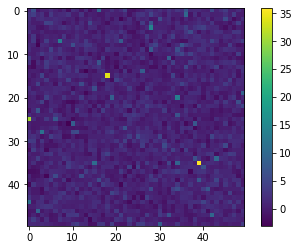

In [242]:
z0 = np.array([0.5, 0.5, 0.5])
x0 = model(z0)
plt.imshow(x0)
plt.colorbar()

In [243]:
z_cpu = swyft.sample_z(NSAMPLES, NDIM)
xz_cpu = swyft.sample_x(model, z_cpu)

100%|██████████| 3000/3000 [00:02<00:00, 1015.91it/s]


In [244]:
xz = []
for entry in tqdm(xz_cpu):
    ex = torch.tensor(entry['x'], dtype = torch.float, device = DEVICE)
    ez = torch.tensor(entry['z'], dtype = torch.float, device = DEVICE)
    xz.append(dict(x = ex, z = ez))
z = swyft.get_z(xz)

100%|██████████| 3000/3000 [00:00<00:00, 8170.10it/s]


## Inference network

### Head network for feature definition

In [245]:
class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [246]:
ydim = Head().cuda()(torch.tensor(x0).float().cuda().unsqueeze(0)).shape[1]  # Number of output features per image
print(ydim)

160


In [247]:
net = swyft.Network(xdim = ydim, zdim = NDIM, head = Head().cuda()).to(DEVICE).train()

In [248]:
loss  = swyft.train(net, xz, n_train = NTRAIN, lr = 1e-3, device = DEVICE, n_batch = NBATCH)

100%|██████████| 3000/3000 [00:41<00:00, 72.46it/s]


In [ ]:
loss += swyft.train(net, xz, n_train = NTRAIN, lr = 1e-4, device = DEVICE, n_batch = NBATCH)

  7%|▋         | 215/3000 [00:02<00:38, 72.84it/s]

In [ ]:
loss += swyft.train(net, xz, n_train = NTRAIN, lr = 1e-5, device = DEVICE, n_batch = NBATCH)

In [ ]:
z0 = np.array([0.4, 0.5, 0.6])
x0 = model(z0)
post = swyft.get_posteriors(net, x0, z, device = DEVICE)

In [ ]:
for i in range(NDIM):
    zp = post[i]['z']
    lnLp = np.exp(post[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
#plt.ylim([-10, 0])